# General purpose code

In [ ]:
pip install tensorflow_addons

In [ ]:
import os
import re
import sys
import time
import datetime
import math
import pandas as pd
import numpy as np
import cv2
import random
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator,\
load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Layer, \
LayerNormalization, MultiHeadAttention, Add, Embedding
from tensorflow.keras.metrics import Precision, Recall, TruePositives
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, \
EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential, load_model, Model
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import keras.backend as K
from typing import Any, List, Tuple, Union

print(tf.__version__)

In [ ]:
# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

In [ ]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int(sec_elapsed % (60 * 60)) / 60
  s = sec_elapsed % 60
  return f'{h}:{m:>02}:{s:>05.2f}'

In [ ]:
def path_of_output_dir(outdir, run_desc):
    prev_run_dirs = []
    if os.path.isdir(outdir):
        prev_run_dirs = [x for x in os.listdir(outdir) if os.path.isdir(\
            os.path.join(outdir, x))]
    prev_run_ids = [re.match(r'^\d+', x) for x in prev_run_dirs]
    prev_run_ids = [int(x.group()) for x in prev_run_ids if x is not None]
    last_run_id = max(prev_run_ids, default=-1)
    run_dir = os.path.join(outdir, f'{last_run_id:05d}-{run_desc}')
    
    return run_dir

In [ ]:
def path_of_model_on_epoch(outdir, run_desc, epoch):
    run_dir = path_of_output_dir(outdir, run_desc)
    files = os.listdir(run_dir)
    if epoch < 10:
        pat = f'^model-0{epoch}.+'
    else: 
        pat = f'^model-{epoch}.+'
    file_name = [re.match(pat, x) for x in files]
    file_name = [x.group() for x in file_name if x is not None]

    return os.path.join(run_dir, file_name[0])

In [ ]:
def generate_output_dir(outdir, run_desc):
    prev_run_dirs = []
    if os.path.isdir(outdir):
        prev_run_dirs = [x for x in os.listdir(outdir) if os.path.isdir(\
            os.path.join(outdir, x))]
    prev_run_ids = [re.match(r'^\d+', x) for x in prev_run_dirs]
    prev_run_ids = [int(x.group()) for x in prev_run_ids if x is not None]
    cur_run_id = max(prev_run_ids, default=-1) + 1
    run_dir = os.path.join(outdir, f'{cur_run_id:05d}-{run_desc}')
    assert not os.path.exists(run_dir)
    os.makedirs(run_dir)
    return run_dir

In [ ]:
class Logger(object):
    """Redirect stderr to stdout, optionally print stdout to a file, and 
    optionally force flushing on both stdout and the file."""

    def __init__(self, file_name: str = None, file_mode: str = "w", \
                 should_flush: bool = True):
        self.file = None

        if file_name is not None:
            self.file = open(file_name, file_mode)

        self.should_flush = should_flush
        self.stdout = sys.stdout
        self.stderr = sys.stderr

        sys.stdout = self
        sys.stderr = self

    def __enter__(self) -> "Logger":
        return self

    def __exit__(self, exc_type: Any, exc_value: Any, traceback: Any) -> None:
        self.close()

    def write(self, text: str) -> None:
        """Write text to stdout (and a file) and optionally flush."""
        if len(text) == 0: 
            return

        if self.file is not None:
            self.file.write(text)

        self.stdout.write(text)

        if self.should_flush:
            self.flush()

    def flush(self) -> None:
        """Flush written text to both stdout and a file, if open."""
        if self.file is not None:
            self.file.flush()

        self.stdout.flush()

    def close(self) -> None:
        """Flush, close possible files, and remove stdout/stderr mirroring."""
        self.flush()

        # if using multiple loggers, prevent closing in wrong order
        if sys.stdout is self:
            sys.stdout = self.stdout
        if sys.stderr is self:
            sys.stderr = self.stderr

        if self.file is not None:
            self.file.close()

In [ ]:
if not os.path.isdir('DFG-tsr-aug-test-dataset'):
    from pathlib import Path

    base = Path('drive/MyDrive/datasets')
    
    if os.path.isdir(base):
        filenames = [x for x in os.listdir(base)]
        print(filenames)
    for zipfile in filenames:
        zip_path = base/zipfile
        print(zip_path)
        !cp '{zip_path}' .

    ! unzip -q DFG-tsr-aug-train-dataset.zip
    ! unzip -q DFG-tsr-aug-test-dataset.zip
    ! unzip -q DFG-tsr-aug-train-labels.zip
    ! unzip -q DFG-tsr-aug-test-labels.zip
    # ! unzip -q GTSRB_Final_Training_Images.zip 
    # ! unzip -q GTSRB_Final_Test_Images.zip 
    # ! unzip -q GTSRB_Final_Test_GT.zip

    !rm GTSRB_Final_Training_Images.zip
    !rm GTSRB_Final_Test_Images.zip
    !rm GTSRB_Final_Test_GT.zip
    !rm DFG-tsr-aug-train-dataset.zip
    !rm DFG-tsr-aug-test-dataset.zip
    !rm DFG-tsr-aug-train-labels.zip
    !rm DFG-tsr-aug-test-labels.zip

# Images from dataset

In [ ]:
### LOADING TRAINING DATASET 
train_data_dir = os.path.abspath('DFG-tsr-aug-train-dataset')
os.path.exists(train_data_dir)

True

In [ ]:
### LOADING TEST DATASET
test_data_dir = os.path.abspath('DFG-tsr-aug-test-dataset')
os.path.exists(test_data_dir)

True

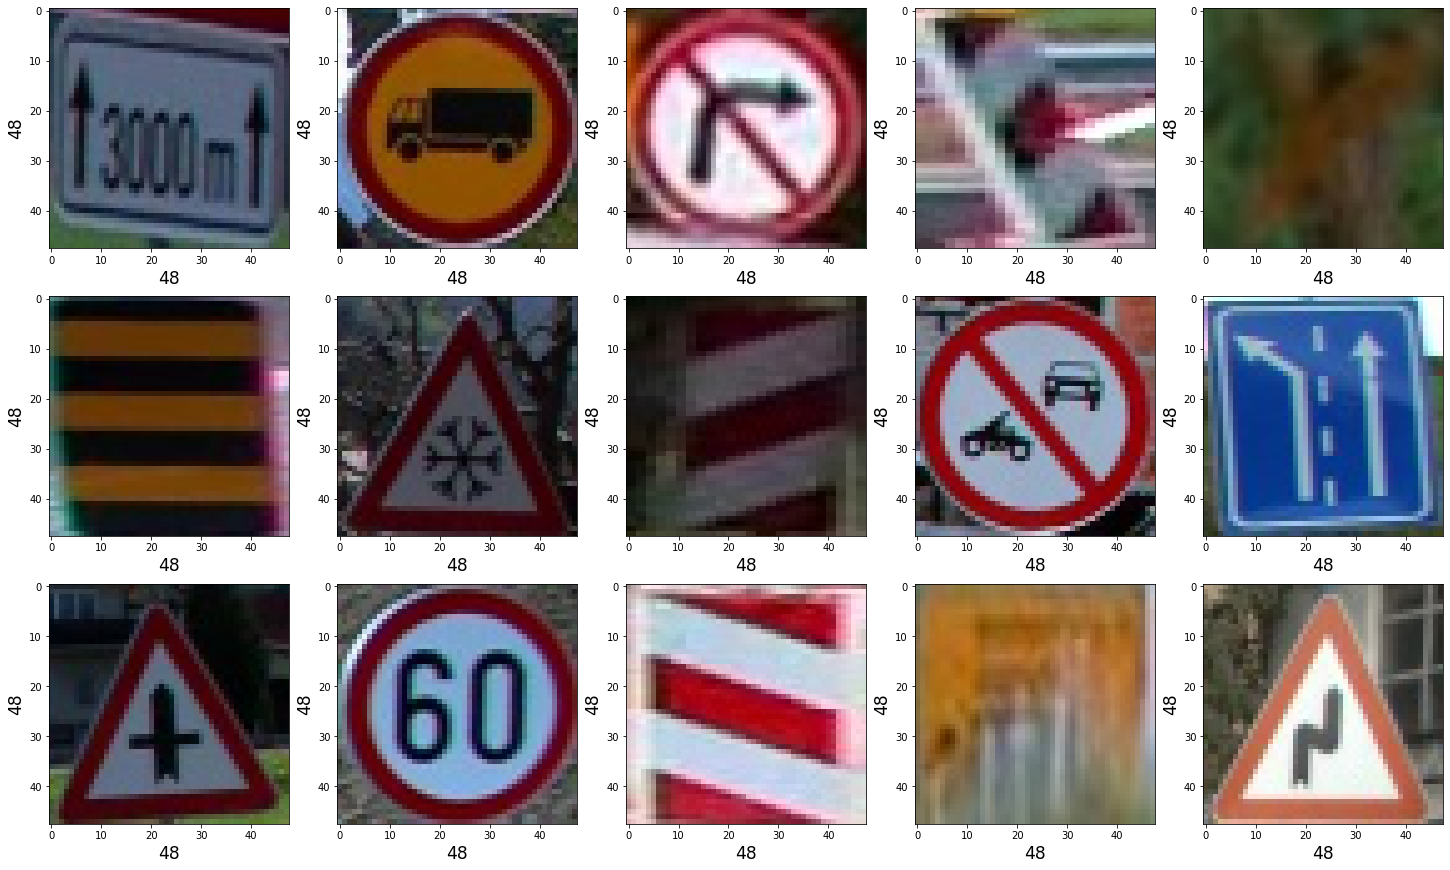

In [ ]:
# Visualizing 15 random images
import random
from matplotlib.image import imread

test = pd.read_csv('test_labels.csv', sep=',')
imgs = test['Filename'].values
imgs_to_plot = []

plt.figure(figsize=(25,15))

for i in range(1,16):
    plt.subplot(3,5,i)
    rand_img = random.choice(imgs)
    random_img_path = os.path.join(test_data_dir, rand_img)
    imgs_to_plot.append(test[test['Filename']==rand_img])
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 17)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 17)#height of image

imgs_to_plot_df = pd.concat(imgs_to_plot)

# Loading dataset

In [ ]:
size = (48, 48)

In [ ]:
### Loading dataset (training)
train_images = []
train_labels = []

csv_file = pd.read_csv('train_labels.csv', sep=',')
for row in csv_file.iterrows() :
    img_path = os.path.join(train_data_dir, row[1].Filename)
    img = load_img(img_path)
    img = img_to_array(img)
    # img = cv2.imread(img_path)
    img = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)
    train_images.append(img)
    train_labels.append(row[1].ClassId)

In [ ]:
### Loading dataset(test)
test_images = []
test_labels = []

csv_file = pd.read_csv('test_labels.csv', sep=',')
for row in csv_file.iterrows() :
    img_path = os.path.join(test_data_dir, row[1].Filename)
    img = load_img(img_path)
    img = img_to_array(img)
    # img = cv2.imread(img_path)
    img = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)
    test_images.append(img)
    test_labels.append(row[1].ClassId)

# Data preprocessing

In [ ]:
print(f'Train images: {len(train_labels)}')
print(f'Test images: {len(test_labels)}')

Train images: 40274
Test images: 4392


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Traffic sign count')

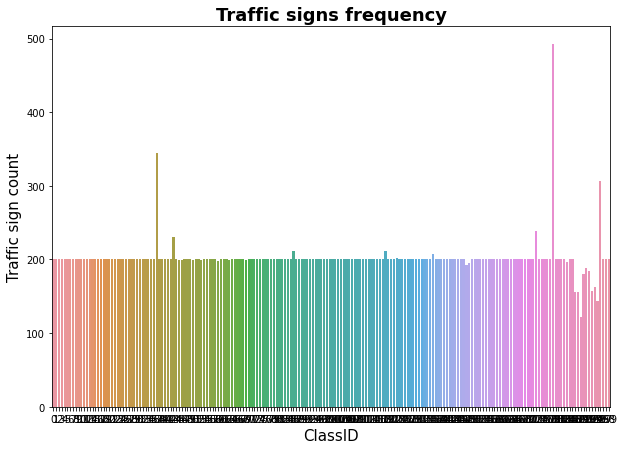

In [ ]:
### Histogram (balance between classes in training set)

countplt, ax = plt.subplots(figsize = (10,7))
ax = sns.countplot(train_labels)
ax.set_title('Traffic signs frequency',fontsize = 18, fontweight='bold' )
ax.set_xlabel('ClassID', fontsize = 15)
ax.set_ylabel('Traffic sign count', fontsize = 15)

In [ ]:
X_train = np.asarray(train_images)

In [ ]:
X_test = np.asarray(test_images)

In [ ]:
### to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
print(f'Train images: {len(y_train)}')
print(f'Validation images: {len(y_val)}')
print(f'Test images: {len(y_test)}')

Train images: 32219
Validation images: 8055
Test images: 4392


In [ ]:
### Data Standardization

X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

# # calculate per-channel means and standard deviations
# X_train_mean = np.mean(X_train, axis=(0,1))
# X_train_std = np.std(X_train, axis=(0,1))

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

# Architecture

In [ ]:
### Hyper-Parameters
epochs = 100
lr = 1e-3
optimizer = Adam(learning_rate=lr) #lr = 1e-3
# optimizer = RMSprop(learning_rate=lr) #lr = 1e-3
# optimizer = SGD(learning_rate=lr) #1e-1 
# optimizer = tfa.optimizers.SGDW(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=1e-4) #lr = 1e-2

batch_size = 50
num_classes = 200
input_shape = X_test.shape
input_shape = input_shape[1:4]
# input_shape = (48, 48, 3)
image_size = input_shape[0]  # We'll resize input images to this size
patch_size = 4 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        return {
            'patch_size': self.patch_size,
        }

Image size: 48 X 48
Patch size: 4 X 4
Patches per image: 144
Elements per patch: 48


<Figure size 288x288 with 0 Axes>

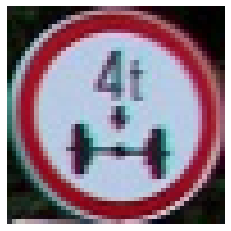

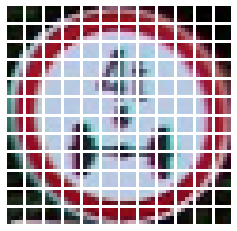

In [ ]:
plt.figure(figsize=(4, 4))
test = pd.read_csv('test_labels.csv', sep=',')
imgs = test['Filename'].values

plt.figure(figsize=(4,4))
rand_img = random.choice(imgs)
random_img_path = os.path.join(test_data_dir, rand_img)
# rand_img = imread(random_img_path)
image = imread(random_img_path)
# image = cv2.resize(rand_img, size, interpolation = cv2.INTER_LINEAR)
plt.imshow(image)
plt.axis("off")

image = tf.convert_to_tensor([image])
patches = Patches(patch_size)(image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        return {
            'num_patches': self.num_patches,
            'projection_dim': self.projection_dim,
        }

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [ ]:
def create_vit_classifier():
    inputs = Input(shape=input_shape)
    # # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation) 
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits)
    return model

# Model run

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def build_model():
    model = create_vit_classifier()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy', Precision(), Recall(), f1_score])

    model.summary()
    return model

In [ ]:
def scheduler(epoch):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(0.1 * (20 - epoch))

In [ ]:
### Training the model

def train_model(model, initial_epoch=0, max_epochs=100):
    start_time = time.time()

    checkpoint_cb = ModelCheckpoint(
        os.path.join(run_dir, 'model-{epoch:02d}-acc-{accuracy:.3f}-val_loss-{val_loss:.3f}.hdf5'),
        monitor='val_loss', save_best_only=True, verbose=0)

    csv_log = CSVLogger(os.path.join(run_dir, "results.csv"), append=True)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

    earlystop = EarlyStopping(monitor = 'val_loss', 
                            min_delta = 2e-4,
                            patience = 10,  
                            restore_best_weights = True)
    
    callbacks = [earlystop, csv_log, checkpoint_cb, lr_callback] 

    # Train model
    hist = model.fit(X_train.reshape(-1, input_shape[0], input_shape[1], input_shape[2]), 
                    y_train, 
                    epochs=max_epochs, 
                    initial_epoch=initial_epoch,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    return hist

In [ ]:
outdir = './data/'
run_desc = "val-train"

run_dir = generate_output_dir(outdir, run_desc)
print(f"Results saved to: {run_dir}")

with Logger(os.path.join(run_dir, 'train_log.txt')):
    model = build_model()
    hist = train_model(model, max_epochs=epochs)

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()

In [ ]:
best_epoch = int(input('Enter epoch with best testing accuracy:'))
BEST_MODEL_PATH = path_of_model_on_epoch(outdir, 'val-train', best_epoch)
model = load_model(BEST_MODEL_PATH, compile=False)

with Logger(os.path.join(run_dir, 'test_log.txt')):
    loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)

In [ ]:
def conf_matrix(predictions, y_test, classes=y_train.shape[1], figsize=(24, 20)):
    y_pred = np.argmax(predictions, axis=-1)
    y_test_sparse = np.argmax(y_test, axis=-1)

    cf_matrix = confusion_matrix(y_test_sparse, y_pred)

    #Prepare visuals
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
                zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(classes,classes)

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
### Confusion Matrix

# best_epoch = int(input('Enter epoch with best testing accuracy:'))
# BEST_MODEL_PATH = path_of_model_on_epoch(outdir, 'test-train', best_epoch)
# BEST_MODEL_PATH = path_of_model_on_epoch(outdir, 'cont-train', best_epoch)
# model = load_model(BEST_MODEL_PATH, compile=False,
#                    custom_objects={'Patches': Patches, 
#                                    'PatchEncoder': PatchEncoder})                   

predictions = model.predict(X_test)

conf_matrix(predictions, y_test)